# * Business Growth Overview

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

## Import Data Source

In [324]:
data_src = "Raw-Agg Perf Nationwide_Wk 2023022.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']

''' Fix Metric CD '''
prepaid_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']
tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"
bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list
# bg_rev_sum_cd_list = ['DB1R000100', 'TB1R000100', 'DB2R000100', 'TB2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # Exclude : Total of PRE & POST
# bg_rev_sum_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

''' Fix Agg Column Name '''
# bg_act_col_list = ['ACT_POST_DTAC', 'ACT_POST_TMH', 'ACT_PRE_DTAC', 'ACT_PRE_TMH', 'ACT_TDG', 'ACT_TOL', 'ACT_TVS']
bg_act_col_list = ['ACT_POST', 'ACT_PRE', 'ACT_TDG', 'ACT_TOL', 'ACT_TVS']
bg_tgt_col_list = ['TGT_POST', 'TGT_PRE', 'TGT_TDG', 'TGT_TOL', 'TGT_TVS']
bg_last_act_col_list = ['LAST_ACT_POST', 'LAST_ACT_PRE', 'LAST_ACT_TDG', 'LAST_ACT_TOL', 'LAST_ACT_TVS']

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
df = df[df['TM_KEY_DAY'] <= 20230605] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)].reset_index()
df.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,COMP_CD,...,SEQ,PRIORITY,REMARK,AREA_TYPE,AREA_CD,AREA_NAME,REMARK_ACTUAL,REMARK_TARGET,PPN_TM,METRIC_NAME_GROUP
870,46751,20230603,2023022,202306,20232,2023,Saturday,June,Quarter 2,TRUE,...,2386.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-07 17:44:33,TVS Revenue
871,46752,20230604,2023022,202306,20232,2023,Sunday,June,Quarter 2,TRUE,...,2386.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-07 17:44:33,TVS Revenue
872,46753,20230605,2023023,202306,20232,2023,Monday,June,Quarter 2,TRUE,...,2386.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-07 17:44:33,TVS Revenue


In [325]:
df.shape
# df['METRIC_NAME'].unique()

(873, 55)

In [326]:
# ''' Find Metric '''

# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# # df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # # df_tmp.to_excel('Prepaid_Metric.xlsx')
# # df_tmp

## Data Preporation

In [327]:
''' Function : Unit Million Baht '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')

In [328]:
''' Datetime values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df[['TM_KEY_YR', 'TM_KEY_WK']].drop_duplicates()['TM_KEY_WK'].shift().max()

curr_day = df['TM_KEY_DAY'].max()
last_ppn_tm = df['PPN_TM'].max()

df = df.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']].reset_index()
df.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,METRIC_CD,METRIC_NAME,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM
870,870,20230603,2023022,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN,2023-06-07 17:44:33
871,871,20230604,2023022,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN,2023-06-07 17:44:33
872,872,20230605,2023023,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN,2023-06-07 17:44:33


In [329]:
# ''' Datetime values '''
# curr_yr = max(df['TM_KEY_YR'])
# last_yr = max(df['TM_KEY_YR'])-1
# curr_mth = max(df['TM_KEY_MTH'])
# curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
# last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
# curr_wk = max(df['TM_KEY_WK'])

# # df_period_wk = df[['TM_KEY_YR', 'TM_KEY_WK']].drop_duplicates()
# # df_period_wk['LAST_WK'] = df_period_wk['TM_KEY_WK'].shift()
# # last_wk = max(df_period_wk[df_period_wk['TM_KEY_WK']==curr_wk]['LAST_WK'])
# last_wk = df[['TM_KEY_YR', 'TM_KEY_WK']].drop_duplicates()['TM_KEY_WK'].shift().max()

# curr_day = max(df['TM_KEY_DAY'])
# last_ppn_tm = max(df['PPN_TM'])

# df = df.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']].reset_index()
# df.tail(3)

### DAY : Aggregation (base level)

In [330]:
''' Group by '''
df_rev_day = df.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC'])\
    .agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()

''' Aggregation '''
df_rev_day['%ACHV'] = df_rev_day['ACTUAL_SNAP'] / df_rev_day['TARGET_SNAP']
df_rev_day['GAP'] = df_rev_day['ACTUAL_SNAP'] - df_rev_day['TARGET_SNAP']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_day['DIFF'] = df_rev_day['ACTUAL_SNAP'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACTUAL_SNAP'] / df_rev_day['LAST_ACT']) - 1
# df_rev_day['ACT_BG'] = df_rev_day[df_rev_yr['METRIC_CD'].isin(bg_rev_sum_cd_list)]['ACTUAL_SNAP']
# df_rev_day['TGT_BG'] = df_rev_day[df_rev_yr['METRIC_CD'].isin(bg_rev_sum_cd_list)]['TARGET_SNAP']

# df_rev_day.to_excel('df_rev_mth.xlsx')
df_rev_day.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%DOD
868,TNSC00142,TDG Revenue (Performance View),20230601,2023022,202306,20232,2023,June,0.0,0.0,NaN,0.0,0.0,0.0,NaN
869,TNSC00142,TDG Revenue (Performance View),20230602,2023022,202306,20232,2023,June,0.0,0.0,NaN,0.0,0.0,0.0,NaN
870,TNSC00142,TDG Revenue (Performance View),20230603,2023022,202306,20232,2023,June,0.0,0.0,NaN,0.0,0.0,0.0,NaN
871,TNSC00142,TDG Revenue (Performance View),20230604,2023022,202306,20232,2023,June,0.0,0.0,NaN,0.0,0.0,0.0,NaN
872,TNSC00142,TDG Revenue (Performance View),20230605,2023023,202306,20232,2023,June,0.0,0.0,NaN,0.0,0.0,0.0,NaN


In [331]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_day_act = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
pv_rev_day_act.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                                'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                                'TDG Revenue (Performance View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
pv_rev_day_tgt = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
pv_rev_day_tgt.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                                'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                                'TDG Revenue (Performance View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_day_achv = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='%ACHV').reset_index()
pv_rev_day_achv.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                 'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                 'TDG Revenue (Performance View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
pv_rev_day_gap = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='GAP').reset_index()
pv_rev_day_gap.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                                'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                                'TDG Revenue (Performance View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_day_last_act = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='LAST_ACT').reset_index()
pv_rev_day_last_act.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                     'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                     'TDG Revenue (Performance View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_day_diff = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='DIFF').reset_index()
pv_rev_day_diff.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                 'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                 'TDG Revenue (Performance View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot % DOD '''
pv_rev_day_dod = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='%DOD').reset_index()
pv_rev_day_dod.rename(columns=({'Postpaid Revenue': '%DOD_POST', 'Postpaid Revenue : DTAC': '%DOD_POST_DTAC', 'Postpaid Revenue : TMH': '%DOD_POST_TMH', 
                                'Prepaid Revenue': '%DOD_PRE', 'Prepaid Revenue : DTAC': '%DOD_PRE_DTAC', 'Prepaid Revenue : TMH': '%DOD_PRE_TMH', 
                                'TDG Revenue (Performance View)': '%DOD_TDG', 'TOL Revenue': '%DOD_TOL', 'TVS Revenue': '%DOD_TVS'}), inplace=True)

''' Merge all dataframe '''
all_pv_day = [pv_rev_day_act, pv_rev_day_tgt, pv_rev_day_achv, pv_rev_day_gap, pv_rev_day_last_act, pv_rev_day_diff, pv_rev_day_dod]
df_rev_day_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_DAY'), all_pv_day)

''' Add new column '''
df_rev_day_agg['WK_LABEL'] = df_rev_day_agg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_rev_day_agg['DAY_LABEL'] = df_rev_day_agg['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df_rev_day_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,...,%DOD_POST_DTAC,%DOD_POST_TMH,%DOD_PRE,%DOD_PRE_DTAC,%DOD_PRE_TMH,%DOD_TDG,%DOD_TOL,%DOD_TVS,WK_LABEL,DAY_LABEL
94,20230603,2023022,202306,20232,2023,June,0.0,97.676929,0.0,129.269069,...,-0.607754,-1.0,-0.068121,-0.051030,-0.081067,NaN,NaN,NaN,22,3
95,20230604,2023022,202306,20232,2023,June,0.0,97.417088,0.0,119.263478,...,-0.002660,NaN,-0.077401,-0.062709,-0.088895,NaN,NaN,NaN,22,4
96,20230605,2023023,202306,20232,2023,June,0.0,94.137850,0.0,0.000000,...,-0.033662,NaN,-1.000000,0.011072,-1.000000,NaN,NaN,NaN,23,5


In [332]:
''' Add column for BG Summary '''

df_rev_day_agg['ACT_BG'] = df_rev_day_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_day_agg['TGT_BG'] = df_rev_day_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_day_agg['%ACHV_BG'] = df_rev_day_agg['ACT_BG'] / df_rev_day_agg['TGT_BG']
df_rev_day_agg['GAP_BG'] = df_rev_day_agg['ACT_BG'] - df_rev_day_agg['TGT_BG']
df_rev_day_agg['LAST_ACT_BG'] = df_rev_day_agg[list(bg_last_act_col_list)].sum(axis=1)
# df_rev_day_agg['DIFF_BG_TMP'] = df_rev_day_agg.apply(lambda x: 0 if x['LAST_ACT_BG']<=0 else x['ACT_BG']-x['LAST_ACT_BG'], axis=1)
df_rev_day_agg['DIFF_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, df_rev_day_agg['ACT_BG']-df_rev_day_agg['LAST_ACT_BG'])
df_rev_day_agg['%DOD_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, (df_rev_day_agg['ACT_BG']/df_rev_day_agg['LAST_ACT_BG'])-1)

df_rev_day_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,...,%DOD_TVS,WK_LABEL,DAY_LABEL,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%DOD_BG
94,20230603,2023022,202306,20232,2023,June,0.0,97.676929,0.0,129.269069,...,NaN,22,3,129.269069,124.539946,1.037973,4.729123,979.557466,-850.288397,-0.868033
95,20230604,2023022,202306,20232,2023,June,0.0,97.417088,0.0,119.263478,...,NaN,22,4,119.263478,123.392007,0.966541,-4.128529,129.269069,-10.005591,-0.077401
96,20230605,2023023,202306,20232,2023,June,0.0,94.137850,0.0,0.000000,...,NaN,23,5,0.000000,0.000000,NaN,0.000000,119.263478,-119.263478,-1.000000


## ** Yearly

### YR : Aggregation

In [333]:
''' Group by '''
df_rev_yr = df.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()

''' Aggregation '''
df_rev_yr['%ACHV'] = (df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['TARGET_SNAP'])
df_rev_yr['GAP'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['TARGET_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['LAST_ACT']) - 1

# df_rev_yr.to_excel('df_rev_yr.xlsx')
df_rev_yr.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
4,TB1R000100,Prepaid Revenue : TMH,2023,6503.052722,6422.564636,1.012532,80.488087,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2023,11534.497102,11540.644816,0.999467,-6.147715,NaN,NaN,NaN
6,TB3R000100,TOL Revenue,2023,4079.219788,4520.496458,0.902383,-441.276670,NaN,NaN,NaN
7,TB4R000100,TVS Revenue,2023,782.042385,1240.849037,0.630248,-458.806652,NaN,NaN,NaN
8,TNSC00142,TDG Revenue (Performance View),2023,7141.721325,6743.000000,1.059131,398.721325,NaN,NaN,NaN


In [334]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_yr_act = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_yr_act.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                               'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                               'TDG Revenue (Performance View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
pv_rev_yr_tgt = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
pv_rev_yr_tgt.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                               'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                               'TDG Revenue (Performance View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_yr_achv = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='%ACHV').reset_index()
pv_rev_yr_achv.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                'TDG Revenue (Performance View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
pv_rev_yr_gap = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='GAP').reset_index()
pv_rev_yr_gap.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                               'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                               'TDG Revenue (Performance View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_yr_last_act = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='LAST_ACT').reset_index()
pv_rev_yr_last_act.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                    'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                    'TDG Revenue (Performance View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_yr_diff = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='DIFF').reset_index()
pv_rev_yr_diff.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                'TDG Revenue (Performance View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot % YoY '''
pv_rev_yr_yoy = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='%YOY').reset_index()
pv_rev_yr_yoy.rename(columns=({'Postpaid Revenue': '%YOY_POST', 'Postpaid Revenue : DTAC': '%YOY_POST_DTAC', 'Postpaid Revenue : TMH': '%YOY_POST_TMH', 
                               'Prepaid Revenue': '%YOY_PRE', 'Prepaid Revenue : DTAC': '%YOY_PRE_DTAC', 'Prepaid Revenue : TMH': '%YOY_PRE_TMH', 
                               'TDG Revenue (Performance View)': '%YOY_TDG', 'TOL Revenue': '%YOY_TOL', 'TVS Revenue': '%YOY_TVS'}), inplace=True)

''' Merge all dataframe '''
all_pv_yr = [pv_rev_yr_act, pv_rev_yr_tgt, pv_rev_yr_achv, pv_rev_yr_gap, pv_rev_yr_last_act, pv_rev_yr_diff, pv_rev_yr_yoy]
df_rev_yr_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_YR'), all_pv_yr)
df_rev_yr_agg

METRIC_NAME,TM_KEY_YR,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,ACT_TVS,...,DIFF_TVS,%YOY_POST,%YOY_POST_DTAC,%YOY_POST_TMH,%YOY_PRE,%YOY_PRE_DTAC,%YOY_PRE_TMH,%YOY_TDG,%YOY_TOL,%YOY_TVS
0,2023,20690.35239,9445.087155,11534.497102,11535.208678,5085.924521,6503.052722,7141.721325,4079.219788,782.042385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
''' Add column for BG Summary '''

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg[list(bg_last_act_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

METRIC_NAME,TM_KEY_YR,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,ACT_TVS,...,%YOY_TDG,%YOY_TOL,%YOY_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%YOY_BG
0,2023,20690.35239,9445.087155,11534.497102,11535.208678,5085.924521,6503.052722,7141.721325,4079.219788,782.042385,...,NaN,NaN,NaN,44228.544567,44889.87636,0.985268,-661.331794,0.0,0.0,0.0


In [336]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_PRE_TMH']
y_yr_act_tdg = df_rev_yr_agg['ACT_TDG']
y_yr_act_tol = df_rev_yr_agg['ACT_TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_PRE_TMH']
y_yr_tgt_tdg = df_rev_yr_agg['TGT_TDG']
y_yr_tgt_tol = df_rev_yr_agg['TGT_TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV_POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV_POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV_POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV_PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV_PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV_PRE_TMH']
y_yr_achv_tdg = df_rev_yr_agg['%ACHV_TDG']
y_yr_achv_tol = df_rev_yr_agg['%ACHV_TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV_TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP_POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP_POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP_POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP_PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP_PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP_PRE_TMH']
y_yr_gap_tdg = df_rev_yr_agg['GAP_TDG']
y_yr_gap_tol = df_rev_yr_agg['GAP_TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP_TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT_POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT_POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT_POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT_PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT_PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT_PRE_TMH']
y_yr_last_act_tdg = df_rev_yr_agg['LAST_ACT_TDG']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT_TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT_TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF_POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF_POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF_POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF_PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF_PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF_PRE_TMH']
y_yr_diff_tdg = df_rev_yr_agg['DIFF_TDG']
y_yr_diff_tol = df_rev_yr_agg['DIFF_TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF_TVS']

''' % YoY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY_POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY_POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY_POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY_PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY_PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY_PRE_TMH']
y_yr_yoy_tdg = df_rev_yr_agg['%YOY_TDG']
y_yr_yoy_tol = df_rev_yr_agg['%YOY_TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY_TVS']


### YR : Business Growth Revenue Summary

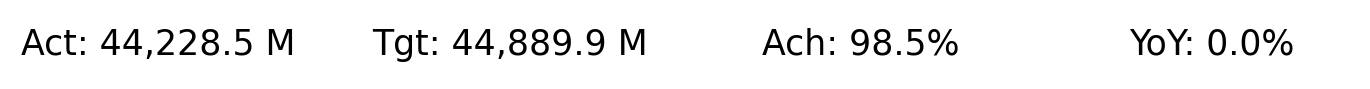

In [337]:
''' Yearly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_yr_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_yr_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_yr_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(y_yr_yoy.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

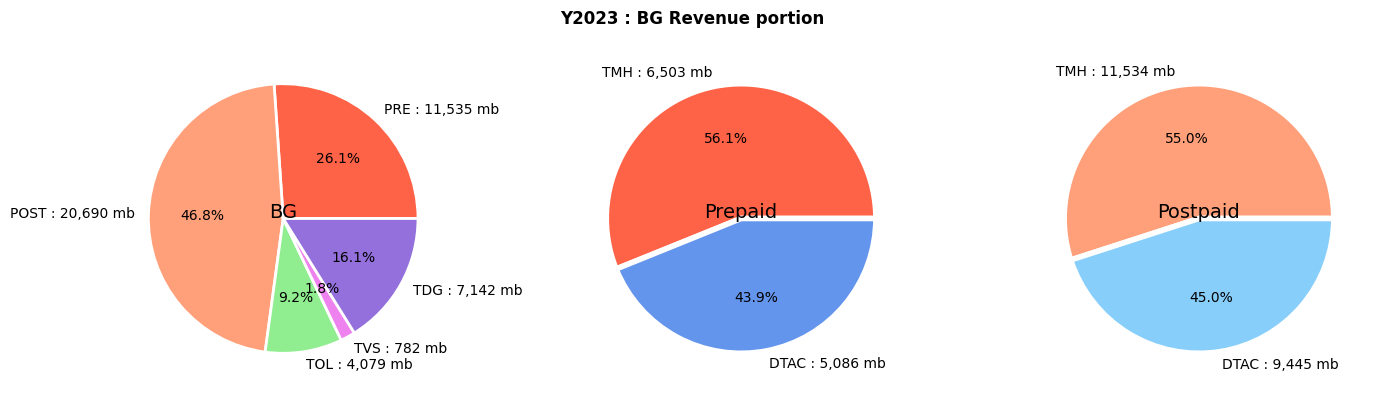

In [338]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(14.3, 4))
fig.suptitle(f'Y{curr_yr} : BG Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum(), y_yr_act_tdg.sum()])
mylabels = [f"PRE : {format(y[0],',.0f')} mb", f"POST : {format(y[1],',.0f')} mb", f"TOL : {format(y[2],',.0f')} mb", f"TVS : {format(y[3],',.0f')} mb", f"TDG : {format(y[4],',.0f')} mb"]
mycolors = ["tomato", "lightsalmon", "lightgreen", "violet",  "mediumpurple"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 2, "edgecolor": "white"})
ax1.text(0, 0, 'BG', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["tomato", "cornflowerblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly

### MTH : Aggregation

In [339]:
''' Month to Date Values '''

last_act_day = df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_BG']>0)]['DAY_LABEL'].max()
mtd_last_act = df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==last_mth) & (df_rev_day_agg['DAY_LABEL']<=last_act_day)]['ACT_BG'].sum()
# mtd_last_act = sum(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==last_mth) & (df_rev_day_agg['DAY_LABEL']<=last_act_day)][['ACT_BG']].sum())
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_BG'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_BG'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [340]:
''' Group by '''
df_rev_mth = df.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()

''' Aggregation '''
df_rev_mth['%ACHV'] = (df_rev_mth['ACTUAL_SNAP'] / df_rev_mth['TARGET_SNAP'])
df_rev_mth['GAP'] = df_rev_mth['ACTUAL_SNAP'] - df_rev_mth['TARGET_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACTUAL_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACTUAL_SNAP'] / df_rev_mth['LAST_ACT']) - 1

# df_rev_mth.to_excel('df_rev_mth.xlsx')
df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
31,TB4R000100,TVS Revenue,202306,June,0.000000,0.0,NaN,0.000000,236.218241,-236.218241,-1.00000
32,TNSC00142,TDG Revenue (Performance View),202303,March,2294.948805,2088.0,1.099113,206.948805,NaN,NaN,NaN
33,TNSC00142,TDG Revenue (Performance View),202304,April,2060.772520,2140.0,0.962978,-79.227480,2294.948805,-234.176284,-0.10204
34,TNSC00142,TDG Revenue (Performance View),202305,May,2786.000000,2515.0,1.107753,271.000000,2060.772520,725.227480,0.35192
35,TNSC00142,TDG Revenue (Performance View),202306,June,0.000000,0.0,NaN,0.000000,2786.000000,-2786.000000,-1.00000


In [341]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_mth_act = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_mth_act.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                                'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                                'TDG Revenue (Performance View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
pv_rev_mth_tgt = df_rev_mth.pivot(index=['TM_KEY_MTH'], columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
pv_rev_mth_tgt.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                                'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                                'TDG Revenue (Performance View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_mth_achv = df_rev_mth.pivot(index=['TM_KEY_MTH'], columns='METRIC_NAME', values='%ACHV').reset_index()
pv_rev_mth_achv.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                 'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                 'TDG Revenue (Performance View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
pv_rev_mth_gap = df_rev_mth.pivot(index=['TM_KEY_MTH'], columns='METRIC_NAME', values='GAP').reset_index()
pv_rev_mth_gap.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                                'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                                'TDG Revenue (Performance View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_mth_last_act = df_rev_mth.pivot(index=['TM_KEY_MTH'], columns='METRIC_NAME', values='LAST_ACT').reset_index()
pv_rev_mth_last_act.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                     'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                     'TDG Revenue (Performance View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_mth_diff = df_rev_mth.pivot(index=['TM_KEY_MTH'], columns='METRIC_NAME', values='DIFF').reset_index()
pv_rev_mth_diff.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                 'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                 'TDG Revenue (Performance View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot % MoM '''
pv_rev_mth_mom = df_rev_mth.pivot(index=['TM_KEY_MTH'], columns='METRIC_NAME', values='%MOM').reset_index()
pv_rev_mth_mom.rename(columns=({'Postpaid Revenue': '%MOM_POST', 'Postpaid Revenue : DTAC': '%MOM_POST_DTAC', 'Postpaid Revenue : TMH': '%MOM_POST_TMH', 
                                'Prepaid Revenue': '%MOM_PRE', 'Prepaid Revenue : DTAC': '%MOM_PRE_DTAC', 'Prepaid Revenue : TMH': '%MOM_PRE_TMH', 
                                'TDG Revenue (Performance View)': '%MOM_TDG', 'TOL Revenue': '%MOM_TOL', 'TVS Revenue': '%MOM_TVS'}), inplace=True)

''' Merge all dataframe '''
all_pv_mth = [pv_rev_mth_act, pv_rev_mth_tgt, pv_rev_mth_achv, pv_rev_mth_gap, pv_rev_mth_last_act, pv_rev_mth_diff, pv_rev_mth_mom]
df_rev_mth_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_MTH'), all_pv_mth)
df_rev_mth_agg

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,...,DIFF_TVS,%MOM_POST,%MOM_POST_DTAC,%MOM_POST_TMH,%MOM_PRE,%MOM_PRE_DTAC,%MOM_PRE_TMH,%MOM_TDG,%MOM_TOL,%MOM_TVS
0,202303,March,6603.140796,2983.888468,3619.252328,3683.557615,1620.241312,2063.316303,2294.948805,1401.402760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202304,April,6654.114487,2960.554432,3693.560055,3584.677321,1569.575558,2015.101763,2060.772520,1405.515708,...,1.566500,0.007720,-0.007820,0.020531,-0.026844,-0.031270,-0.023367,-0.10204,0.002935,0.005756
2,202305,May,6582.934680,2953.069229,3629.865451,3733.741967,1610.280929,2123.461039,2786.000000,1272.301320,...,-37.477081,-0.010697,-0.002528,-0.017245,0.041584,0.025934,0.053774,0.35192,-0.094780,-0.136930
3,202306,June,850.162427,547.575026,591.819268,533.231775,285.826722,301.173618,0.000000,0.000000,...,-236.218241,-0.870854,-0.814574,-0.836958,-0.857186,-0.822499,-0.858169,-1.00000,-1.000000,-1.000000


In [342]:
''' Add column for BG Summary '''

df_rev_mth_agg['ACT_BG'] = df_rev_mth_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_mth_agg['TGT_BG'] = df_rev_mth_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_mth_agg['%ACHV_BG'] = df_rev_mth_agg['ACT_BG'] / df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['GAP_BG'] = df_rev_mth_agg['ACT_BG'] - df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['LAST_ACT_BG'] = df_rev_mth_agg[list(bg_last_act_col_list)].sum(axis=1)
df_rev_mth_agg['DIFF_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, df_rev_mth_agg['ACT_BG']-df_rev_mth_agg['LAST_ACT_BG'])
df_rev_mth_agg['%MOM_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, (df_rev_mth_agg['ACT_BG']/df_rev_mth_agg['LAST_ACT_BG'])-1)

df_rev_mth_agg.tail(3)

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,...,%MOM_TDG,%MOM_TOL,%MOM_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%MOM_BG
1,202304,April,6654.114487,2960.554432,3693.560055,3584.677321,1569.575558,2015.101763,2060.77252,1405.515708,...,-0.10204,0.002935,0.005756,13978.775358,14372.510932,0.972605,-393.735575,14255.178798,-276.403441,-0.019390
2,202305,May,6582.934680,2953.069229,3629.865451,3733.741967,1610.280929,2123.461039,2786.00000,1272.301320,...,0.35192,-0.094780,-0.136930,14611.196209,14758.253305,0.990036,-147.057096,13978.775358,632.420851,0.045242
3,202306,June,850.162427,547.575026,591.819268,533.231775,285.826722,301.173618,0.00000,0.000000,...,-1.00000,-1.000000,-1.000000,1383.394201,1399.565859,0.988445,-16.171658,14611.196209,-13227.802008,-0.905320


In [343]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Actual '''
y_mth_act = df_rev_mth_agg['ACT_BG']
y_mth_act_post = df_rev_mth_agg['ACT_POST']
y_mth_act_post_dtac = df_rev_mth_agg['ACT_POST_DTAC']
y_mth_act_post_tmh = df_rev_mth_agg['ACT_POST_TMH']
y_mth_act_pre = df_rev_mth_agg['ACT_PRE']
y_mth_act_pre_dtac = df_rev_mth_agg['ACT_PRE_DTAC']
y_mth_act_pre_tmh = df_rev_mth_agg['ACT_PRE_TMH']
y_mth_act_tdg = df_rev_mth_agg['ACT_TDG']
y_mth_act_tol = df_rev_mth_agg['ACT_TOL']
y_mth_act_tvs = df_rev_mth_agg['ACT_TVS']

''' Target '''
y_mth_tgt = df_rev_mth_agg['TGT_BG']
y_mth_tgt_post = df_rev_mth_agg['TGT_POST']
y_mth_tgt_post_dtac = df_rev_mth_agg['TGT_POST_DTAC']
y_mth_tgt_post_tmh = df_rev_mth_agg['TGT_POST_TMH']
y_mth_tgt_pre = df_rev_mth_agg['TGT_PRE']
y_mth_tgt_pre_dtac = df_rev_mth_agg['TGT_PRE_DTAC']
y_mth_tgt_pre_tmh = df_rev_mth_agg['TGT_PRE_TMH']
y_mth_tgt_tdg = df_rev_mth_agg['TGT_TDG']
y_mth_tgt_tol = df_rev_mth_agg['TGT_TOL']
y_mth_tgt_tvs = df_rev_mth_agg['TGT_TVS']

''' % Achievement '''
y_mth_achv = df_rev_mth_agg['%ACHV_BG']
y_mth_achv_post = df_rev_mth_agg['%ACHV_POST']
y_mth_achv_post_dtac = df_rev_mth_agg['%ACHV_POST_DTAC']
y_mth_achv_post_tmh = df_rev_mth_agg['%ACHV_POST_TMH']
y_mth_achv_pre = df_rev_mth_agg['%ACHV_PRE']
y_mth_achv_pre_dtac = df_rev_mth_agg['%ACHV_PRE_DTAC']
y_mth_achv_pre_tmh = df_rev_mth_agg['%ACHV_PRE_TMH']
y_mth_achv_tdg = df_rev_mth_agg['%ACHV_TDG']
y_mth_achv_tol = df_rev_mth_agg['%ACHV_TOL']
y_mth_achv_tvs = df_rev_mth_agg['%ACHV_TVS']

''' Gap '''
y_mth_gap = df_rev_mth_agg['GAP_BG']
y_mth_gap_post = df_rev_mth_agg['GAP_POST']
y_mth_gap_post_dtac = df_rev_mth_agg['GAP_POST_DTAC']
y_mth_gap_post_tmh = df_rev_mth_agg['GAP_POST_TMH']
y_mth_gap_pre = df_rev_mth_agg['GAP_PRE']
y_mth_gap_pre_dtac = df_rev_mth_agg['GAP_PRE_DTAC']
y_mth_gap_pre_tmh = df_rev_mth_agg['GAP_PRE_TMH']
y_mth_gap_tdg = df_rev_mth_agg['GAP_TDG']
y_mth_gap_tol = df_rev_mth_agg['GAP_TOL']
y_mth_gap_tvs = df_rev_mth_agg['GAP_TVS']

''' Last Actual '''
y_mth_last_act = df_rev_mth_agg['LAST_ACT_BG']
y_mth_last_act_post = df_rev_mth_agg['LAST_ACT_POST']
y_mth_last_act_post_dtac = df_rev_mth_agg['LAST_ACT_POST_DTAC']
y_mth_last_act_post_tmh = df_rev_mth_agg['LAST_ACT_POST_TMH']
y_mth_last_act_pre = df_rev_mth_agg['LAST_ACT_PRE']
y_mth_last_act_pre_dtac = df_rev_mth_agg['LAST_ACT_PRE_DTAC']
y_mth_last_act_pre_tmh = df_rev_mth_agg['LAST_ACT_PRE_TMH']
y_mth_last_act_tdg = df_rev_mth_agg['LAST_ACT_TDG']
y_mth_last_act_tol = df_rev_mth_agg['LAST_ACT_TOL']
y_mth_last_act_tvs = df_rev_mth_agg['LAST_ACT_TVS']

''' Diff Last Actual '''
y_mth_diff = df_rev_mth_agg['DIFF_BG']
y_mth_diff_post = df_rev_mth_agg['DIFF_POST']
y_mth_diff_post_dtac = df_rev_mth_agg['DIFF_POST_DTAC']
y_mth_diff_post_tmh = df_rev_mth_agg['DIFF_POST_TMH']
y_mth_diff_pre = df_rev_mth_agg['DIFF_PRE']
y_mth_diff_pre_dtac = df_rev_mth_agg['DIFF_PRE_DTAC']
y_mth_diff_pre_tmh = df_rev_mth_agg['DIFF_PRE_TMH']
y_mth_diff_tdg = df_rev_mth_agg['DIFF_TDG']
y_mth_diff_tol = df_rev_mth_agg['DIFF_TOL']
y_mth_diff_tvs = df_rev_mth_agg['DIFF_TVS']

''' % MoM '''
y_mth_mom = df_rev_mth_agg['%MOM_BG']
y_mth_mom_post = df_rev_mth_agg['%MOM_POST']
y_mth_mom_post_dtac = df_rev_mth_agg['%MOM_POST_DTAC']
y_mth_mom_post_tmh = df_rev_mth_agg['%MOM_POST_TMH']
y_mth_mom_pre = df_rev_mth_agg['%MOM_PRE']
y_mth_mom_pre_dtac = df_rev_mth_agg['%MOM_PRE_DTAC']
y_mth_mom_pre_tmh = df_rev_mth_agg['%MOM_PRE_TMH']
y_mth_mom_tdg = df_rev_mth_agg['%MOM_TDG']
y_mth_mom_tol = df_rev_mth_agg['%MOM_TOL']
y_mth_mom_tvs = df_rev_mth_agg['%MOM_TVS']


### MTH : Business Growth Revenue Summary

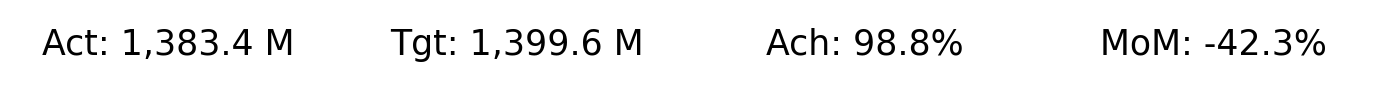

In [344]:
''' Monthly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

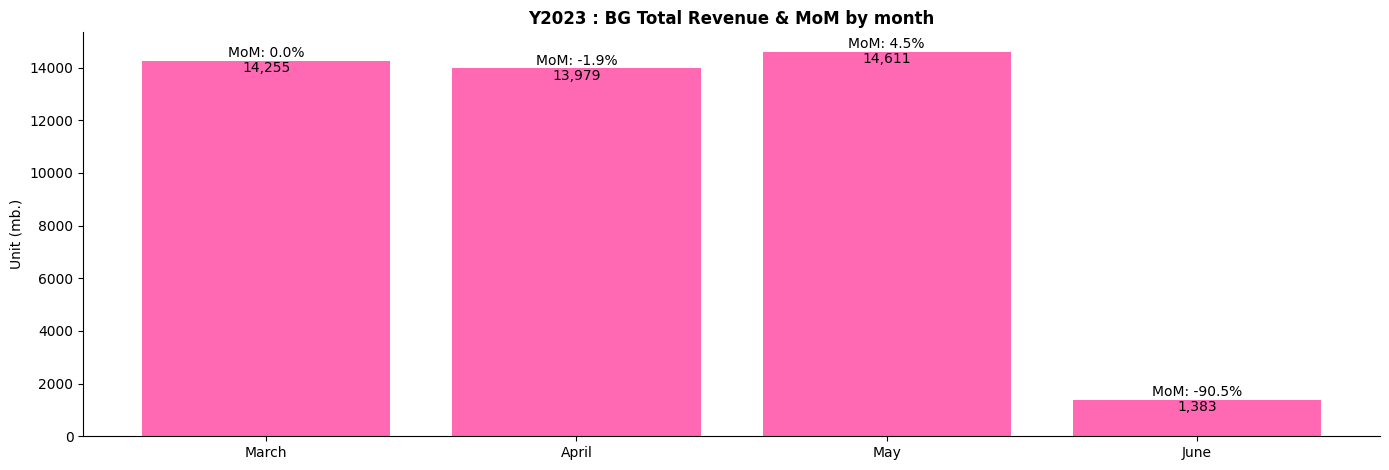

In [345]:
''' Total Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Total Revenue & MoM by month", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='hotpink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
# plt.legend()
plt.tight_layout()
plt.show()

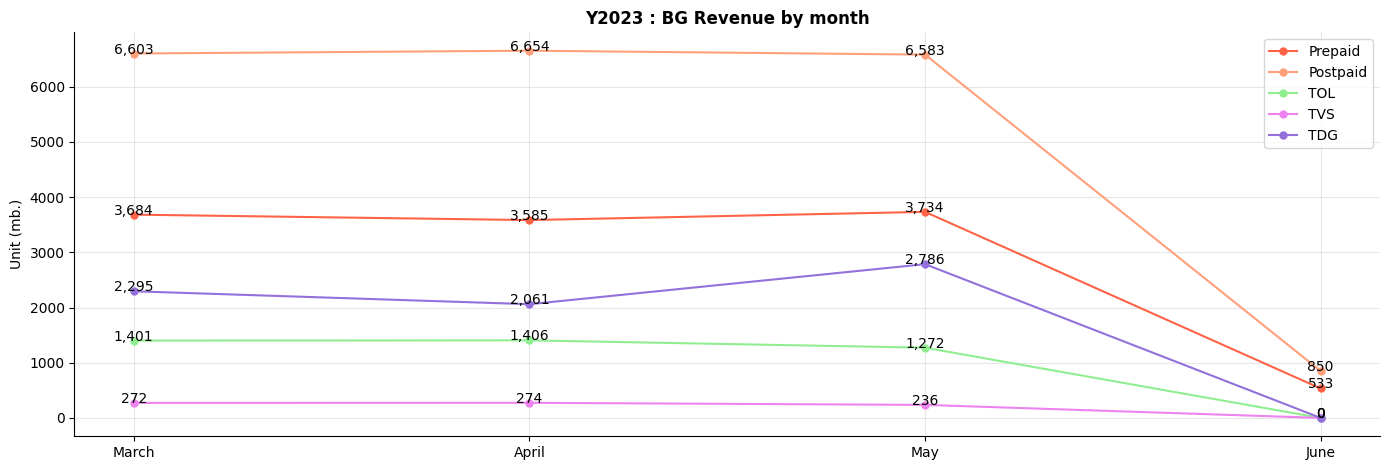

In [346]:
''' Revenue : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre, marker='.', markeredgewidth=3, label='Prepaid', color='tomato')
plt.plot(x_mth_axis, y_mth_act_post, marker='.', markeredgewidth=3, label='Postpaid', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre[i]), ha='center')
    plt.annotate(format(y_mth_act_post[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post[i]), ha='center')
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center')
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center')
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

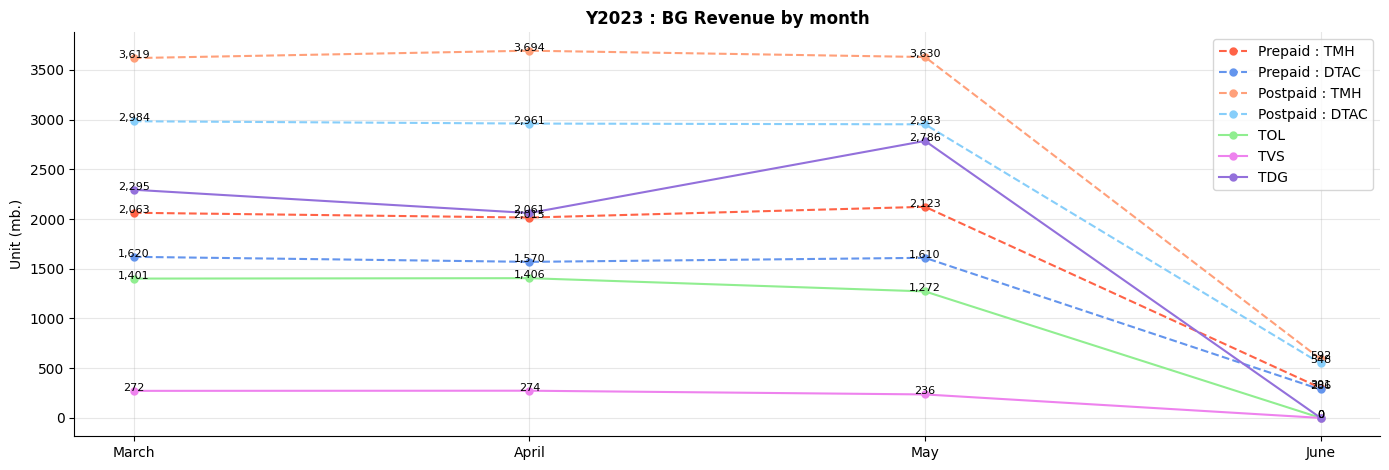

In [347]:
''' Revenue(Mobile separated by TMH, DTAC) : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Prepaid : TMH', color='tomato')
plt.plot(x_mth_axis, y_mth_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Prepaid : DTAC', color='cornflowerblue')
plt.plot(x_mth_axis, y_mth_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Postpaid : TMH', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Postpaid : DTAC', color='lightskyblue')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_pre_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Weekly

### WK : Aggregation

In [356]:
''' Week to Date Values '''

curr_wk_day_cnt = df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].drop_duplicates().count()
wtd_last_act = df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==last_wk)].head(curr_wk_day_cnt)['ACT_BG'].sum()
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_BG'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_BG'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4972/637993816.py:7: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv = wtd_act / wtd_tgt
/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4972/637993816.py:8: RuntimeWarning: invalid value encountered in scalar divide
  wtd_wow = (wtd_act / wtd_last_act) - 1


In [357]:
curr_wk_day_cnt

0

### WK : Business Growth Revenue Summary

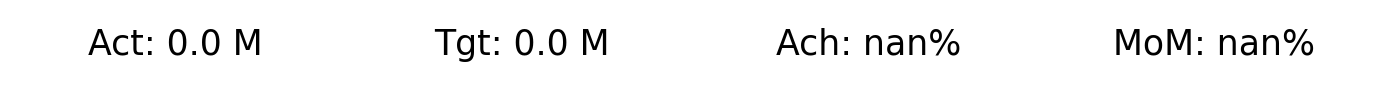

In [358]:
''' Weekly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(wtd_wow,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()